In [6]:
####################################
###  Fetch data and Preprocess  ###

import nltk
from nltk.corpus.reader import *
from nltk import flatten


# Read the dataset 
train = ConllCorpusReader('data',
                          're3d-train.conll',
                          ['words', 'pos'])


test = ConllCorpusReader('data', 
                         're3d-test.conll',
                          ['words', 'pos'])

In [7]:
##couldnt find the method to get NE so it is represented as POS
sentences = train.tagged_sents() + test.tagged_sents()
test_sentences = test.tagged_sents() 

print("Number of training records: " + str(len(train.tagged_sents())))
print("Number of testing records: " + str(len(test.tagged_sents())))
print(sentences[0])

Number of training records: 765
Number of testing records: 200
[('Operation', 'O'), ('Steel', 'O'), ('Curtain', 'O'), ('(', 'O'), ('Arabic', 'O'), (':', 'O'), ('ا', 'O'), ('ل', 'O'), ('ح', 'O'), ('ج', 'O'), ('ا', 'O'), ('ب', 'O'), ('ا', 'O'), ('ل', 'O'), ('ف', 'O'), ('و', 'O'), ('ل', 'O'), ('ا', 'O'), ('ذ', 'O'), ('ي', 'O'), ('Al', 'O'), ('Hejab', 'O'), ('Elfulathi', 'O'), (')', 'O'), ('was', 'O'), ('a', 'O'), ('military', 'O'), ('operation', 'O'), ('executed', 'O'), ('by', 'O'), ('coalition', 'B-Organisation'), ('forces', 'I-Organisation'), ('in', 'O'), ('early', 'B-Temporal'), ('November', 'I-Temporal'), ('2005', 'I-Temporal'), ('to', 'O'), ('reduce', 'O'), ('the', 'O'), ('flow', 'O'), ('of', 'O'), ('foreign', 'B-Organisation'), ('insurgents', 'I-Organisation'), ('crossing', 'O'), ('the', 'O'), ('border', 'O'), ('and', 'O'), ('joining', 'O'), ('the', 'O'), ('Iraqi', 'B-Nationality'), ('insurgency', 'O'), ('.', 'O')]


In [8]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 154 words


(array([ 71., 173., 219., 202., 146.,  81.,  40.,  13.,  10.,   5.,   3.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,   8.65,  16.3 ,  23.95,  31.6 ,  39.25,  46.9 ,  54.55,
         62.2 ,  69.85,  77.5 ,  85.15,  92.8 , 100.45, 108.1 , 115.75,
        123.4 , 131.05, 138.7 , 146.35, 154.  ]),
 <a list of 20 Patch objects>)

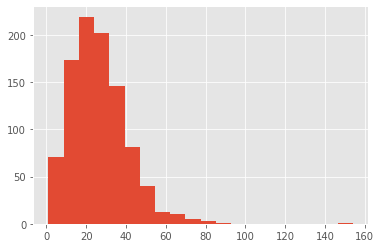

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(sen) for sen in sentences], bins=20)

In [10]:
max_len = 50

X = []
padded_sent = []
x_index = 0
for s in sentences:
    for i in range(max_len):
        if i >= len(s):
            padded_sent.append("xxxPADDINGxxx")
        else:
            padded_sent.append(s[i][0])
    
    X.append(padded_sent)
    padded_sent = []
print (len(X[53]))
print(X[53])

50
['The', 'United', 'States', 'strongly', 'condemns', 'the', 'horrific', 'attacks', 'today', 'in', 'the', 'towns', 'of', 'Jabla', 'in', 'the', 'northwest', 'province', 'of', 'Latakia', ',', 'and', 'the', 'port', 'city', 'of', 'Tartus', ',', 'for', 'which', 'Da', '’', 'esh', 'has', 'claimed', 'responsibility', 'and', 'where', 'more', 'than', '60', 'civilians', 'were', 'killed', 'and', 'injured', 'in', 'multiple', 'bombings', 'that']


In [11]:
tags = []
for s in sentences:
    for w in s:
        tags.append(w[1])
tags = list(set(tags))
num_tags = len(tags)

print(num_tags)

21


In [12]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])

y = [to_categorical(i, num_classes = num_tags) for i in y]

Using TensorFlow backend.


In [13]:
words = []
for s in X:
    for w in s:
        words.append(w)
unique_words = list(set(words))
num_words = len(unique_words)

words2index = { w: i for i,w in enumerate(unique_words) }
X = [[words2index[w] for w in s] for s in X]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=tags2index["xxxPADDINGxxx"])
print(X[1])

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,y, test_size=0.1)

[1631, 3745, 204, 3149, 3674, 2393, 1559, 2974, 1033, 2009, 393, 3548, 3381, 1559, 2383, 2980, 862, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520]


In [14]:
from keras.models import Model, Input, Sequential
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Flatten
import numpy as np

input = Input(shape=(max_len,))
embedding = Embedding(input_dim = num_words, output_dim = 70, input_length = max_len)(input)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=False,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
model = Model(input, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

X_TRAIN, X_TEST = np.array(X_TRAIN), np.array(X_TEST)

In [15]:
batch_size = 32

print('Training...')
model.fit(X_TRAIN, np.array(Y_TRAIN),
          validation_split=0.1,
          batch_size=batch_size,
          epochs=4)

Training...


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 781 samples, validate on 87 samples
Epoch 1/4
781/781 [==============================] - 82s 105ms/step - loss: 0.0745 - accuracy: 0.9804 - val_loss: 0.0550 - val_accuracy: 0.9833
Epoch 2/4
781/781 [==============================] - 79s 101ms/step - loss: 0.0520 - accuracy: 0.9847 - val_loss: 0.0533 - val_accuracy: 0.9833
Epoch 3/4
781/781 [==============================] - 79s 101ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.0514 - val_accuracy: 0.9836
Epoch 4/4
781/781 [==============================] - 78s 100ms/step - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0511 - val_accuracy: 0.9839


In [16]:
from keras.models import model_from_json

i = 27
p = model.predict(np.array([X_TEST[i]]))
p = np.argmax(p, axis=-1)

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_TEST[i],p[0]):
    print("{:14}: {}".format(unique_words[w],tags[pred]))
    
#print(len(X_TRAIN[36]))
#print(words[X_TRAIN[4][1]])

# model.save('inital.model')

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Word           (True ): Pred
Tobias        : O
Ellwood       : O
,             : O
Minister      : O
for           : O
the           : O
Middle        : O
East          : O
welcomes      : O
the           : O
liberation    : O
of            : O
Sinjar        : O
and           : O
reiterates    : O
support       : O
for           : O
the           : O
Government    : O
of            : O
Iraq          : O
in            : O
the           : O
fight         : O
against       : O
ISIL          : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
Saved model to disk
